In [1]:
import matplotlib.pyplot as plt

Keys in the file: ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']
Images dataset shape: (17736, 256, 256, 3)
Images dataset dtype: uint8
Labels dataset shape: (17736,)
Labels dataset dtype: uint8


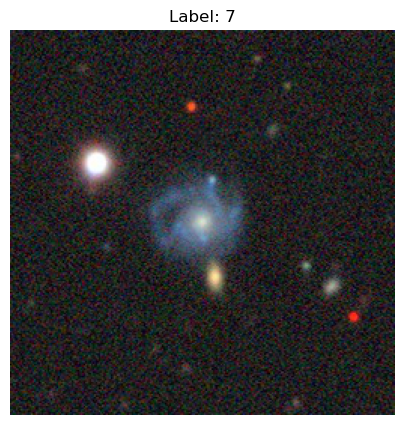

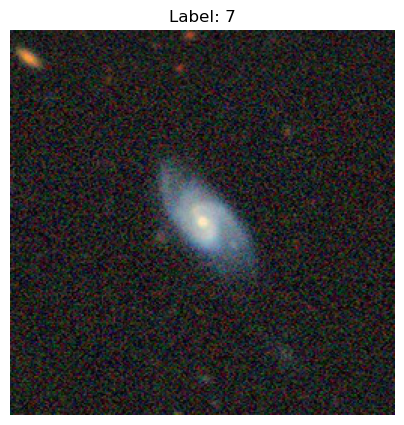

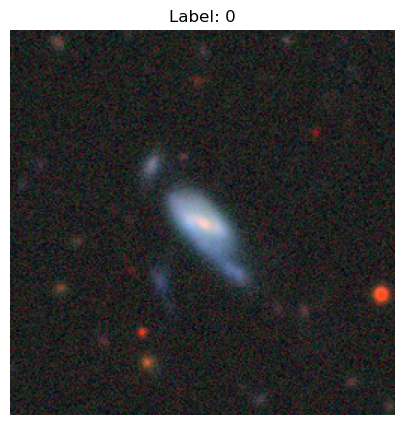

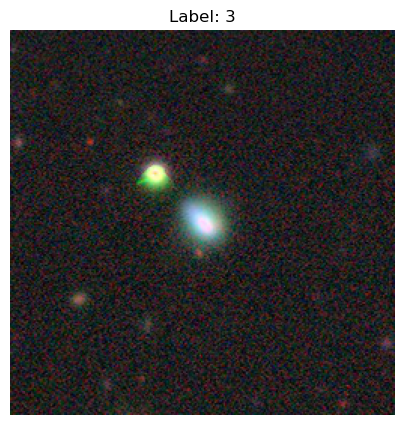

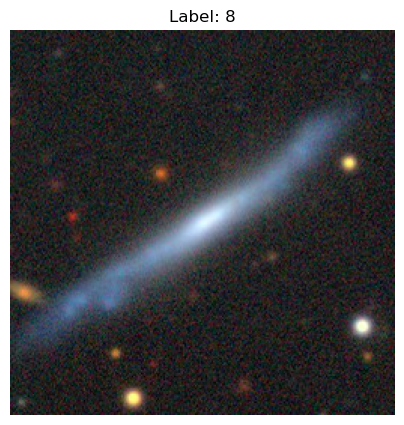

In [3]:
import h5py

# Open the HDF5 file and inspect its contents
file_path = "Galaxy10_DECals.h5"

with h5py.File(file_path, 'r') as f:
    print("Keys in the file:", list(f.keys()))
    images_shape = f['images'].shape
    images_dtype = f['images'].dtype
    labels_shape = f['ans'].shape
    labels_dtype = f['ans'].dtype

    print(f"Images dataset shape: {images_shape}")
    print(f"Images dataset dtype: {images_dtype}")
    print(f"Labels dataset shape: {labels_shape}")
    print(f"Labels dataset dtype: {labels_dtype}")

    import h5py
import numpy as np
import matplotlib.pyplot as plt

# Function to load and visualize a single image
def visualize_single_image(file_path, index):
    with h5py.File(file_path, 'r') as f:
        image = f['images'][index]
        label = f['ans'][index]

        # Plot the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

# 
num_images_to_visualize = 5
with h5py.File(file_path, 'r') as f:
    total_size = len(f['images'])
indices = np.random.choice(total_size, num_images_to_visualize, replace=False)

# 
for idx in indices:
    visualize_single_image(file_path, idx)


In [1]:
import h5py
import numpy as np
import random

with h5py.File("Galaxy10_DECals.h5", 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    
galaxys = images.shape[0]  
train_size = int(0.8 * galaxys)
test_size = galaxys - train_size
    
train_indices = []
test_indices = []
for i in range(galaxys):
    idx = random.randint(0, galaxys-1)
    if i < train_size:
        train_indices.append(idx)
    else:
        test_indices.append(idx)
        
        
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from typing import List, Tuple
from PIL import Image

class GalaDataset(Dataset):
    def __init__(self, images:np.ndarray, labels:np.ndarray, indices:list, transforms) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transforms = transforms
        
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        idx = self.indices[index]
        image = self.images[idx]
        image = Image.fromarray(image)
        label = self.labels[idx]
        # apply transforms
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)
    
    def __len__(self) -> int:
        return len(self.indices)

In [2]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
#    transforms.RandomRotation(degrees=[-30, 30]),
#   transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


train_dataset = GalaDataset(images=images, labels=labels, 
                            indices=train_indices,transforms=train_transforms)

test_dataset = GalaDataset(images=images, labels=labels, 
                            indices=test_indices,transforms=test_transforms)

In [3]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
train_loader.batch_size

64

In [7]:
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from linformer import Linformer
from vit_pytorch.efficient import ViT
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
device

'cuda'

In [19]:
linformer_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [30]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer=linformer_transformer,
    channels=3,
).to(device)

# Fine Tuning Model Code Research - 

## Basic Initial

In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [22]:
def cal_acc(outputs, labels):
    p_arg = torch.argmax(outputs, dim = 1)
    return torch.sum(labels == p_arg)

In [23]:
def train_epoch(model, optimizer, criterion, dataloader, device):
    train_loss = 0
    train_acc = 0
    model.train()
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += cal_acc(outputs, labels).item()
    train_loss = train_loss / len(dataloader.dataset)
    train_acc = train_acc / len(dataloader.dataset)
    
    return train_loss, train_acc

In [24]:
def inference(model, optimizer, criterion, dataloader, device):
    model.eval()
    test_loss=0
    test_acc = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += cal_acc(outputs, labels).item()
        test_loss = test_loss / len(dataloader.dataset)
        test_acc = test_acc / len(dataloader.dataset)
    return test_loss, test_acc

In [25]:
def run(num_epochs, optimizer, criterion, device):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader, device)
        test_loss, test_acc = inference(model, optimizer, criterion, test_loader, device)

        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, test_Loss : {test_loss:.4f}, train_acc : {train_acc:.4f}, test_acc : {test_acc:.4f}')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [ ]:
import time
import datetime

dt_now = datetime.datetime.now()
print("*** Started the Timer at {} ***".format(dt_now))
start_time = time.time()
train_loss_list, test_loss_list, train_acc_list, test_acc_list = run(epochs, optimizer, criterion, device)

# Small Sample Training

In [16]:
import h5py
import numpy as np
import random

with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Use only 100 samples
sample_size = 100
sample_indices = random.sample(range(len(images)), sample_size)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]


In [17]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SampleDataset(Dataset):
    def __init__(self, images, labels, transforms):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.fromarray(self.images[index])
        label = self.labels[index]
        if self.transforms:
            image = self.transforms(image)
        return image, label

    def __len__(self):
        return len(self.images)


In [18]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

batch_size = 32
sample_dataset = SampleDataset(sample_images, sample_labels, train_transforms)
sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=True)


In [27]:
def train_epoch(model, optimizer, criterion, loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), correct / total

def inference(model, optimizer, criterion, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), correct / total


In [28]:
def run(num_epochs, optimizer, criterion, device):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    # Assuming `sample_loader` is used for training and testing
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, sample_loader, device)
        test_loss, test_acc = inference(model, optimizer, criterion, sample_loader, device)

        print(f'Epoch [{epoch+1}], train_Loss: {train_loss:.4f}, test_Loss: {test_loss:.4f}, train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list


In [31]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_loss_list, test_loss_list, train_acc_list, test_acc_list = run(num_epochs, optimizer, criterion, device)


Epoch [1], train_Loss: 2.6198, test_Loss: 2.1478, train_acc: 0.1300, test_acc: 0.1600
Epoch [2], train_Loss: 2.3426, test_Loss: 2.2006, train_acc: 0.1900, test_acc: 0.2600
Epoch [3], train_Loss: 2.0905, test_Loss: 2.1484, train_acc: 0.2000, test_acc: 0.1700
Epoch [4], train_Loss: 2.1720, test_Loss: 2.0380, train_acc: 0.1700, test_acc: 0.1700
Epoch [5], train_Loss: 1.9719, test_Loss: 1.9051, train_acc: 0.3000, test_acc: 0.3200
Epoch [6], train_Loss: 1.8603, test_Loss: 1.7162, train_acc: 0.3500, test_acc: 0.3800
Epoch [7], train_Loss: 1.5923, test_Loss: 1.1407, train_acc: 0.4200, test_acc: 0.7400
Epoch [8], train_Loss: 1.3149, test_Loss: 0.8007, train_acc: 0.7500, test_acc: 0.8000
Epoch [9], train_Loss: 0.6255, test_Loss: 0.4243, train_acc: 0.8400, test_acc: 0.9000
Epoch [10], train_Loss: 0.2924, test_Loss: 0.1726, train_acc: 0.9200, test_acc: 0.9300


# Something different

# Swin Transformer

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import h5py
from tqdm import tqdm
import timm
import random
from torch.cuda.amp import GradScaler, autocast
from typing import List, Tuple

# Set the random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

# Load data from the HDF5 file
file_path = "Galaxy10_DECals.h5"
with h5py.File(file_path, 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Train-test split
galaxys = images.shape[0]
train_size = int(0.8 * galaxys)
indices = np.random.permutation(galaxys)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Custom Dataset class
class GalaDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, indices: List[int], transforms) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transforms = transforms
        
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        idx = self.indices[index]
        image = self.images[idx]
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)
    
    def __len__(self) -> int:
        return len(self.indices)

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as required by the model
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as required by the model
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = GalaDataset(images=images, labels=labels, indices=train_indices, transforms=train_transforms)
test_dataset = GalaDataset(images=images, labels=labels, indices=test_indices, transforms=test_transforms)

batch_size = 8  # Adjust batch size to smaller value
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [2]:
import timm
from tqdm import tqdm

In [3]:
# Load the Swin Transformer model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

# Training function
def train_model(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Validation function
def validate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Free up unused memory
torch.cuda.empty_cache()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the trained model
#torch.save(model.state_dict(), "swin_transformer_galaxy10_decals.pth")


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:31<00:00,  1.34it/s]


Epoch 1/10
Train Loss: 0.7670, Train Acc: 0.7418
Val Loss: 0.5902, Val Acc: 0.8036


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:33<00:00,  1.33it/s]


Epoch 2/10
Train Loss: 0.4631, Train Acc: 0.8447
Val Loss: 0.5810, Val Acc: 0.7968


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:14<00:00,  1.19it/s]


Epoch 3/10
Train Loss: 0.3221, Train Acc: 0.8923
Val Loss: 0.5319, Val Acc: 0.8278


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:06<00:00,  1.21it/s]


Epoch 4/10
Train Loss: 0.2387, Train Acc: 0.9216
Val Loss: 0.5762, Val Acc: 0.8216


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:01<00:00,  1.23it/s]


Epoch 5/10
Train Loss: 0.1883, Train Acc: 0.9380
Val Loss: 0.5254, Val Acc: 0.8430


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [06:00<00:00,  1.23it/s]


Epoch 6/10
Train Loss: 0.1433, Train Acc: 0.9535
Val Loss: 0.6651, Val Acc: 0.8269


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:52<00:00,  1.26it/s]


Epoch 7/10
Train Loss: 0.1325, Train Acc: 0.9579
Val Loss: 0.6982, Val Acc: 0.8247


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:51<00:00,  1.26it/s]


Epoch 8/10
Train Loss: 0.1161, Train Acc: 0.9612
Val Loss: 0.6536, Val Acc: 0.8382


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:51<00:00,  1.26it/s]


Epoch 9/10
Train Loss: 0.0889, Train Acc: 0.9710
Val Loss: 0.7248, Val Acc: 0.8292


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:53<00:00,  1.26it/s]

Epoch 10/10
Train Loss: 0.0892, Train Acc: 0.9709
Val Loss: 0.7296, Val Acc: 0.8292


In [4]:
torch.save(model.state_dict(), "swin_transformer_galaxy10_decals.pth")

# ViT Base Model! -  Finetuned!

In [4]:
from linformer import Linformer
from torchvision.models import resnet50
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import h5py
from tqdm import tqdm
import random
from linformer import Linformer
from torchvision.models import resnet50
from torch.cuda.amp import GradScaler, autocast
from typing import List, Tuple
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Hyperparameters
LR = 5e-5
STEP_SIZE = 5
GAMMA = 0.1
MAX_EPOCH = 200
class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).to(device)
model_name = "gz2_hug_vit_010822B"

# Vision Transformer
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(in_features=768, out_features=10, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

model.to(device)

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Number of trainable parameters: 85806346


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [6]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import StepLR



# Criterion, optimizer and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Training function
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_valid_acc = 0.0
    best_epoch = -1

    # initiate dict to record the history of loss and acc
    history_dic = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train
        model.train()
        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            _, pred_classes = torch.max(outputs.logits.detach(), dim=1)

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                _, pred_classes = torch.max(outputs.logits.detach(), dim=1)
                loss = criterion(outputs.logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

        # Calculate metrics
        train_loss = epoch_train_cum_loss / len(train_loader.dataset)
        train_acc = epoch_train_cum_corrects / len(train_loader.dataset)
        valid_loss = epoch_valid_cum_loss / len(test_loader.dataset)
        valid_acc = epoch_valid_cum_corrects / len(test_loader.dataset)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join('./', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        # Print metrics
        if (epoch + 1) % print_every == 0:
            if epoch == (best_epoch - 1):
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s\t<--")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s")

        # Early stopping
        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break
        
        scheduler.step()

    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training accuracy = {best_train_acc:.4f} and validation accuracy = {best_valid_acc:.4f}")

    return model, history_dic


trained_model, training_history = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler)


Epoch 1/200	Train loss: 0.7708	Train acc: 0.7377	Valid loss: 0.6059	Valid acc: 0.7974	Time: 33m 29s	<--
Epoch 2/200	Train loss: 0.4709	Train acc: 0.8422	Valid loss: 0.5408	Valid acc: 0.8258	Time: 28m 19s	<--
Epoch 3/200	Train loss: 0.3351	Train acc: 0.8870	Valid loss: 0.5290	Valid acc: 0.8224	Time: 23m 53s
Epoch 4/200	Train loss: 0.2360	Train acc: 0.9209	Valid loss: 0.7286	Valid acc: 0.8016	Time: 22m 22s
Epoch 5/200	Train loss: 0.1679	Train acc: 0.9439	Valid loss: 0.6377	Valid acc: 0.8151	Time: 22m 17s
Epoch 6/200	Train loss: 0.0524	Train acc: 0.9847	Valid loss: 0.6198	Valid acc: 0.8334	Time: 22m 18s	<--
Epoch 7/200	Train loss: 0.0256	Train acc: 0.9938	Valid loss: 0.6583	Valid acc: 0.8337	Time: 22m 19s	<--
Epoch 8/200	Train loss: 0.0180	Train acc: 0.9949	Valid loss: 0.6999	Valid acc: 0.8337	Time: 22m 15s
Epoch 9/200	Train loss: 0.0146	Train acc: 0.9955	Valid loss: 0.7065	Valid acc: 0.8391	Time: 23m 16s	<--
Epoch 10/200	Train loss: 0.0116	Train acc: 0.9960	Valid loss: 0.7482	Valid acc: 

In [8]:
## Save the best weights
torch.save(model.state_dict(), 'Decals_ViT_Base_finetuned' + '.pth')
torch.save(model.state_dict(), os.path.join('./', model_name + '.pth'))

# ResNet50

In [2]:
import torch.optim as optim
from torch.optim import lr_scheduler
from copy import deepcopy
import time
import os
import pandas as pd
NUM_OF_CLASSES = 10

In [6]:
import os
import time
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

# Hyperparameters
LR = 1e-5
STEP_SIZE = 10
GAMMA = 0.1
MAX_EPOCH = 200
NUM_OF_CLASSES = 10  # Make sure this matches the number of classes in your dataset

model_name = "gz2_resnet50_A"

# Download the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Change the last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)
print(model.fc)  # Print the modified last layer

print("============")
print("Training")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("============")

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Scheduler
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mkuma\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=10, bias=True)
Training
Number of trainable parameters: 23528522


### Now Training!

In [7]:


# Training function
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=5):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # Cache the best model
    best_model_weights = deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_valid_acc = 0.0
    best_epoch = -1

    # Initiate dict to record the history of loss and acc
    history_dic = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'lr': []
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train
        model.train()
        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, pred_classes = torch.max(outputs.detach(), dim=1)

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                _, pred_classes = torch.max(outputs.detach(), dim=1)
                loss = criterion(outputs, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes == labels.data).detach().to('cpu').item()

        # Calculate metrics
        train_loss = epoch_train_cum_loss / len(train_loader.dataset)
        train_acc = epoch_train_cum_corrects / len(train_loader.dataset)
        valid_loss = epoch_valid_cum_loss / len(test_loader.dataset)
        valid_acc = epoch_valid_cum_corrects / len(test_loader.dataset)

        # Update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # Check if it is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            best_model_weights = deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join('./', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        # Print metrics
        if (epoch + 1) % print_every == 0:
            if epoch == (best_epoch - 1):
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s\t<--")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tValid loss: {valid_loss:.4f}\tValid acc: {valid_acc:.4f}\tTime: {mm:.0f}m {ss:.0f}s")

        # Early stopping
        if (epoch + 1) - best_epoch >= early_stop_epochs:
            print(f"Early stopping... (Model did not improve after {early_stop_epochs} epochs)")
            break
        
        scheduler.step()

    # Load the best weights into the model
    model.load_state_dict(best_model_weights)
    print(f"Best epoch = {best_epoch}, with training accuracy = {best_train_acc:.4f} and validation accuracy = {best_valid_acc:.4f}")

    return model, history_dic

# Assuming `train_loader` and `valid_loader` are your DataLoader instances for the training and validation datasets
trained_model, training_history = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler)


Epoch 1/200	Train loss: 0.9769	Train acc: 0.6792	Valid loss: 0.6965	Valid acc: 0.7666	Time: 5m 54s	<--
Epoch 2/200	Train loss: 0.5921	Train acc: 0.8123	Valid loss: 0.5655	Valid acc: 0.8160	Time: 5m 42s	<--
Epoch 3/200	Train loss: 0.4227	Train acc: 0.8640	Valid loss: 0.6463	Valid acc: 0.7945	Time: 5m 44s
Epoch 4/200	Train loss: 0.3031	Train acc: 0.9047	Valid loss: 0.6075	Valid acc: 0.8193	Time: 5m 44s	<--
Epoch 5/200	Train loss: 0.2112	Train acc: 0.9325	Valid loss: 0.7297	Valid acc: 0.8061	Time: 5m 45s
Epoch 6/200	Train loss: 0.1492	Train acc: 0.9548	Valid loss: 0.7434	Valid acc: 0.8171	Time: 5m 51s
Epoch 7/200	Train loss: 0.1326	Train acc: 0.9601	Valid loss: 0.8295	Valid acc: 0.7858	Time: 6m 3s
Epoch 8/200	Train loss: 0.1056	Train acc: 0.9679	Valid loss: 0.7563	Valid acc: 0.8145	Time: 6m 23s
Epoch 9/200	Train loss: 0.0973	Train acc: 0.9707	Valid loss: 0.8280	Valid acc: 0.8134	Time: 6m 1s
Epoch 10/200	Train loss: 0.0910	Train acc: 0.9717	Valid loss: 0.7845	Valid acc: 0.8148	Time: 6m 2s


In [14]:

## Convert history to dataframe
history_df = pd.DataFrame(training_history)

## Save the history
history_df.to_csv(model_name + '_history.csv')
history_df.to_csv(os.path.join('./', model_name + '_history.csv'))

def func(t):
    return float(t[7:-1])
     

In [16]:
history_df = pd.read_csv(model_name + '_history.csv')



In [17]:
history_df

,Unnamed: 0,train_loss,train_acc,valid_loss,valid_acc,lr
0,0,0.976899,0.679165,0.696476,0.766629,5.000000e-05
1,1,0.592090,0.812306,0.565514,0.815953,5.000000e-05
2,2,0.422693,0.864040,0.646320,0.794532,5.000000e-05
3,3,0.303133,0.904708,0.607478,0.819335,5.000000e-05
4,4,0.211180,0.932549,0.729657,0.806088,5.000000e-05
5,5,0.149223,0.954750,0.743408,0.817080,5.000000e-05
6,6,0.132578,0.960107,0.829474,0.785795,5.000000e-05
7,7,0.105560,0.967860,0.756284,0.814543,5.000000e-05
8,8,0.097296,0.970750,0.827971,0.813416,5.000000e-05
9,9,0.090983,0.971737,0.784519,0.814825,5.000000e-05


In [ ]:


# Assuming `training_history` is a dictionary containing the training history
history_df = pd.DataFrame(training_history)

# Save the history to CSV files
history_df.to_csv(model_name + '_history.csv')
history_df.to_csv(os.path.join('./', model_name + '_history.csv'))

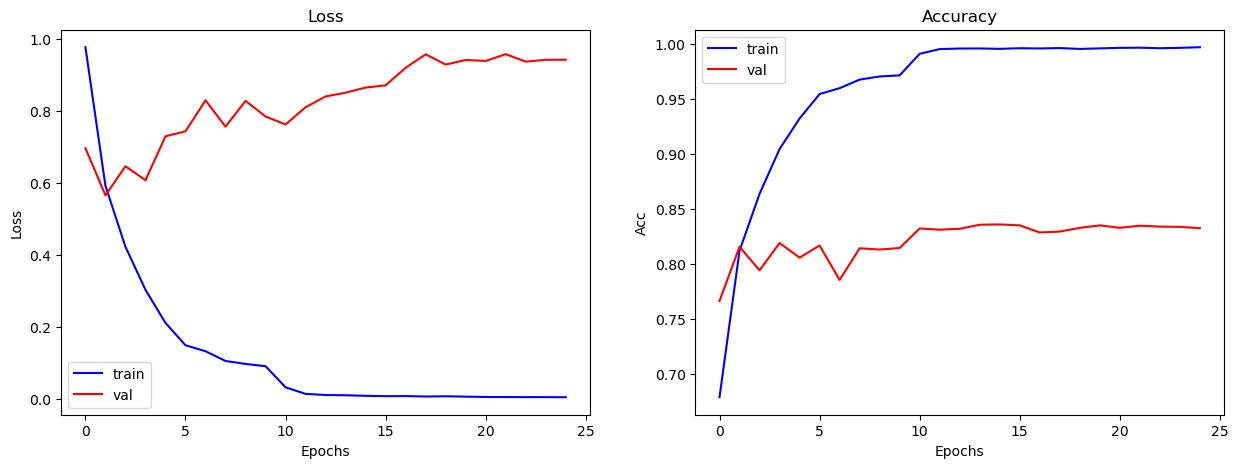

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv("gz2_resnet50_A_history.csv")
# Number of epochs
epochs = len(history_df['valid_acc'])

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_df['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_df['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_df['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_df['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()

plt.show()


# Evaluation

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

def evaluate_model(model, loader, device):
    """
    Evaluate (no gradient tracking) the model on a dataset.
    Args:
        model: the model to be tested
        loader: a custom dataloader
        device: gpu or cpu
    Outputs:
        prints out confusion matrix and several metrics (accuracy, recall, f1)
    """

    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(images)
            _, pred_classes = torch.max(outputs, dim=1)

            y_true += labels.cpu().tolist()
            y_pred += pred_classes.cpu().tolist()
    
    # create a DataFrame with columns 'true labels' and 'predicted labels'
    predict_df = pd.DataFrame(data={'true': y_true, 'pred': y_pred})

    # galaxy classes
    gxy_labels = [
        'Disturbed Galaxies',
        'Merging Galaxies',
        'Round Smooth Galaxies',
        'In-between Round Smooth Galaxies',
        'Cigar Shaped Smooth Galaxies',
        'Barred Spiral Galaxies',
        'Unbarred Tight Spiral Galaxies',
        'Unbarred Loose Spiral Galaxies',
        'Edge-on Galaxies without Bulge',
        'Edge-on Galaxies with Bulge'
    ]
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

    # accuracy of each class
    for c in range(10):
        print(f"Class {c}: accuracy = {cm[c,c]:.4f} ({gxy_labels[c]})")
    print("================")

    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Total Accuracy = {acc:.4f}\n")

    # recall
    recall = recall_score(y_true, y_pred, average='macro')
    print(f"Recall = {recall:.4f}\n")

    # f1 score
    F1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 score = {F1:.4f}\n")

    # plot confusion matrix
    sns.set(font_scale=1.6)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
    plt.show()
